In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Understanding Autodiff with Micrograd

In [2]:
# Sample function

def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

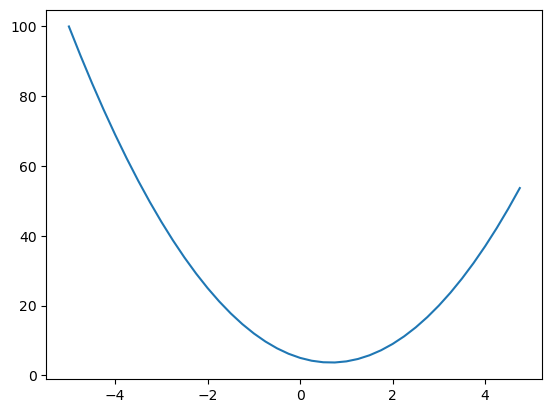

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# Positive slope

h = 0.00000001
x = 3.0
(f(x + h) - f(x)) / h

14.00000009255109

In [6]:
# Negative slope

x = -3.0
(f(x + h) - f(x)) / h

-22.00000039920269

In [7]:
# Zero slope

x = 2/3
(f(x + h) - f(x)) / h

0.0

In [8]:
# Now for more complex functions

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
# Let's find the slope of d with respect to a by increasing a by a small amount h

h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [10]:
# Let's find the slope of d with respect to a by increasing a by a small amount h

h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [11]:
# Let's find the slope of d with respect to a by increasing a by a small amount h

h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


# let's build a Value class to represent a single scalar value, and the operations that can be performed on it

In [40]:
# Let's make a value class

class Value:

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __sub__(self,other):
        out = Value(self.data - other.data, (self, other), '-')
        return out

    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'

## Creating Computational Graphs

In [57]:
from graphviz import Digraph

def trace(root):
    # Builds sets of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build_graph(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build_graph(child)
    build_graph(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR here means left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in graph create a rectangular ('record') node for it
        dot.node(name = uid, label = f"{{ {n.label} | data: {n.data:.4f} | grad: {n.grad:.4f} }}", shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect it to this value node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connec n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

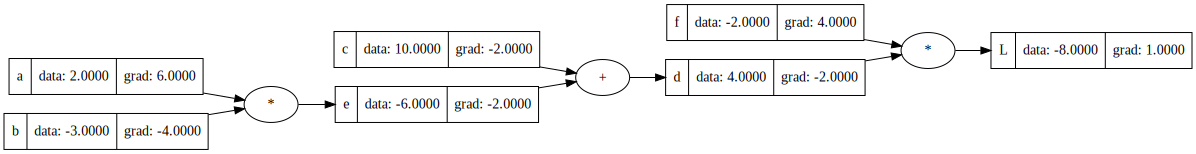

In [58]:
draw_dot(L)

# Manually finding & setting gradients wrt output node

### **A slight demonstration of the chain rule in action when calculating gradients**

Here is a simple breakdown of the chain rule applied to a computational graph:

$ \frac{\partial L}{\partial d} = f $

$ \frac{\partial d}{\partial e} = 1 $

$ \frac{\partial d}{\partial c} = 1 $

Therefore,
$ \frac{\partial L}{\partial e} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial e} = f \cdot 1 = f $

$ \frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial c} = f \cdot 1 = f $

In [55]:
# Setting the found gradient values wrt output node (L)

L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
a.grad = 6.0 # since b = -3.0, and de/da = b and de/da * dL/de = -3 * -2 = 6
b.grad = -4.0 # since a = 2.0, and de/db = a and de/db * dL/de = 2 * -2 = -4

In [59]:
# Manually checking gradients of L wrt a, b, c, d, f, brrr function is to just keep the variables local in scope
# one by one we go backwards and set the gradients by adding h to each variable and seeing how much L changes

def brrr():
    h = 0.0001

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label = 'a')
    a.data += h
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print('grad wrt a', (L2 - L1)/h)
    
brrr()

grad wrt a 6.000000000021544


# Taking a step further and seeing what Neurons and activation functions look like

Let's see how a biologically inspired neuron works. A neuron takes multiple inputs, applies weights to them, adds a bias, and then passes the result through a non-linear activation function (like tanh).

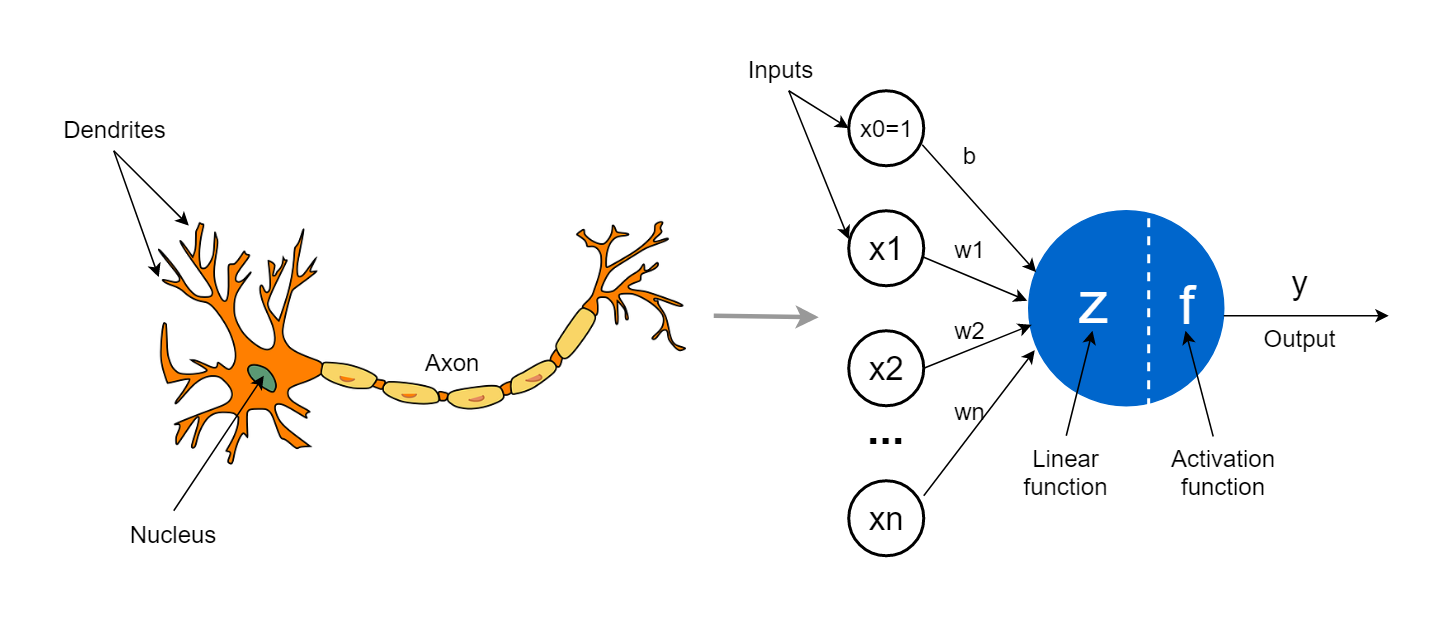

Shown above is a simple neuron with n inputs. The output of the neuron is given after applying the activation function to the weighted sum of inputs plus bias.

the bias term can be thought of as a x0 input with a constant value of 1.0 and a weight equal to the bias.

Weights are the synaptic strengths in a biological neuron, determining how much influence each input has on the output. While the bias is the trigger happiness level of the neuron, determining the threshold at which the neuron activates.

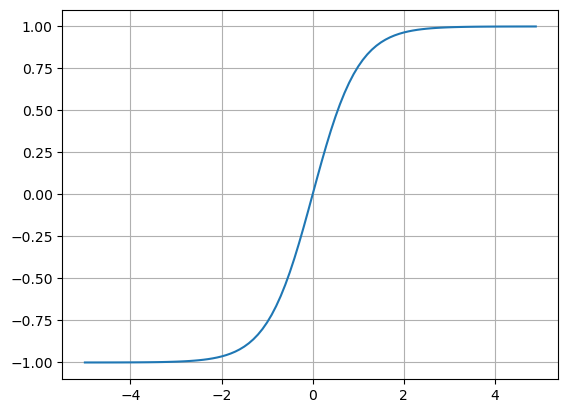

In [ ]:
# Visualizing tanh activation function's squashing property with output range [-1, 1]

plt.plot(np.arange(-5,5,0.1), np.tanh(np.arange(-5,5,0.1)))
plt.grid()

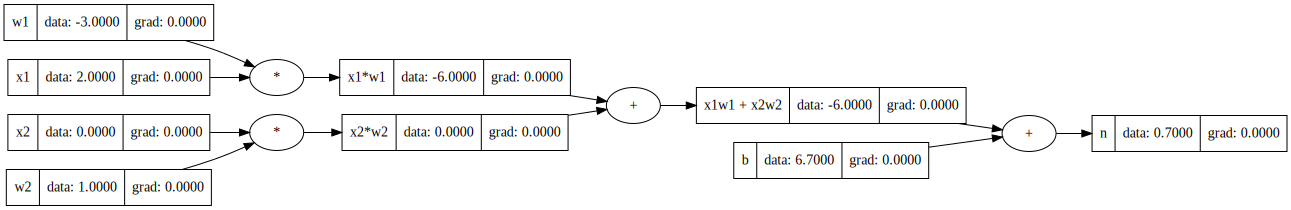

In [ ]:
# inputs of the neuron: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron: b
b = Value(6.7, label='b')

# x1*w1 + x2*w2 + b (step by step)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# applying activation function

draw_dot(n)